In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.linear_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

import sklearn
from collections import Counter 
import imblearn
import mrmr
import matplotlib.pyplot as plt  
import time

In [2]:
data_full = pd.read_csv('/home/jwerner/BrainPower/brainpower/data/unsplit_data/full_data_short.csv')

In [3]:
def handle_scale_and_nan(frame,nandecision='drop',scale='MinMax'):
    features = list(frame.select_dtypes(include='float64'))
    cat = list(frame.select_dtypes(include='object'))

    if scale == 'MinMax':
        scaler = sklearn.preprocessing.MinMaxScaler().fit(frame[features])
    elif scale == 'Standard':
        scaler = sklearn.preprocessing.StandardScaler().fit(frame[features])
        
    df_cont = pd.DataFrame(data=scaler.transform(frame[features]), columns=features)
    df_cat = pd.DataFrame(data=frame[cat], columns=cat)
    
    frame = pd.concat([df_cat,df_cont],axis=1)
    
    if nandecision == 'mean':
            for feature in features:
                frame[feature].fillna((frame[feature].mean()), inplace=True)
    elif nandecision == 'drop':
            frame = frame.dropna(axis=1)
        
    return frame

In [4]:
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')
data_full = data_full.drop(columns='assay_ID')

In [40]:
def split_cats_by_tolerance(frame,tolerance,silent=False,randomstate=None,split=0.15,step=1,target='group',categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
    tolerable_list =[]
    if randomstate == None:
        randomstate=np.random.randint(0,2**31)
    elif type(randomstate) == int:
        pass
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(frame,test_size=split,random_state=randomstate)
        
        dev_dict = dict(df_dev[target].value_counts())
        test_dict = dict(df_test[target].value_counts())
        
        tolerable_list = []
        stats_dict ={}
        for i in range(0,len(categories)):
            try:
                percents = [(dev_dict[categories[i]]/len(df_dev)),(test_dict[categories[i]]/len(df_test))]
            except:
                break
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents],standdev]
            else:
                tolerable_list.append(0)
                
        randomstate += step

    if sum(tolerable_list) == 4:
        if silent == False:
            print(dev_dict)
            print(test_dict)
            print('Randstate:',randomstate-1)
            for i in range(0,len(categories)):            
                print('\nPercent',categories[i],'in dev, test:',stats_dict[categories[i]][0],
                      '\nStandard deviation of these values:',stats_dict[categories[i]][1],'\n')
        elif silent == True:
            pass
            
    return df_dev, df_test


In [19]:
data_dev, data_test = split_cats_by_tolerance(data_full,0.01,randomstate=98281)

{'Healthy': 132, 'AD_MCI': 43, 'PD_MCI_LBD': 32, 'PD': 31}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 98281

Percent Healthy in dev, test: [0.5546218487394958, 0.5714285714285714] 
Standard deviation of these values: 0.008403361344537785 


Percent AD_MCI in dev, test: [0.18067226890756302, 0.19047619047619047] 
Standard deviation of these values: 0.004901960784313722 


Percent PD in dev, test: [0.13025210084033614, 0.11904761904761904] 
Standard deviation of these values: 0.005602240896358551 


Percent PD_MCI_LBD in dev, test: [0.13445378151260504, 0.11904761904761904] 
Standard deviation of these values: 0.007703081232492998 



In [21]:
data_train, data_val = split_cats_by_tolerance(data_dev,0.01,silent=True)

In [ ]:
over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
X_train = df_train_no_excess.drop(columns=['target'])
y_train = df_train_no_excess[target]
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

In [7]:
data_dev['group'].value_counts()

Healthy       132
AD_MCI         43
PD_MCI_LBD     32
PD             31
Name: group, dtype: int64

In [51]:
data_train[data_train['group'] != 'Healthy']

,group,KV37,LV469,LV861,LVX54,LV746,LV218,LV316,LV312,LV310,...,ARMD4,C1QT5,B2L12,PLXA4,B3GN2,PCDGL,AGRB1,RECK,PSA1,F174A
26,AD_MCI,0.555167,0.601355,0.619257,0.455018,0.588982,0.185628,0.031353,0.192312,0.059015,...,0.483644,0.737148,0.478536,0.682939,0.915531,0.783451,0.654821,0.714125,0.528705,0.556611
11,AD_MCI,0.453006,0.355667,0.272653,0.588788,0.000000,0.472498,0.141610,0.743845,0.206886,...,0.015167,0.750584,0.660835,0.503973,0.784545,0.898518,0.704152,0.963255,0.522887,0.752105
229,PD,0.584841,0.490789,0.446167,0.597772,0.231340,0.500490,0.000000,0.099761,0.007491,...,0.748590,0.606980,0.320856,0.840003,0.861846,0.787297,0.566382,0.685657,0.523249,0.531690
225,PD,0.610894,0.667894,0.870614,0.639741,0.934033,0.748129,0.249215,0.473491,0.269067,...,0.497394,0.658960,0.428659,0.458508,0.520775,0.770028,0.572924,0.773222,0.345401,0.601046
1,AD_MCI,0.594054,0.514267,0.585824,0.561601,0.443020,0.437873,0.286198,0.402667,0.275382,...,0.149173,0.420248,0.447687,0.393264,0.651528,0.677561,0.435314,0.889358,0.527576,0.435886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,PD,0.244460,0.478920,0.689313,0.790300,0.687743,0.708925,0.071597,0.240163,0.102348,...,0.699457,0.748570,0.225280,0.504905,0.551573,0.452741,0.563886,0.683208,0.524851,0.532054
45,AD_MCI,0.382461,0.592727,0.582048,0.464521,0.475756,0.460844,0.312535,0.538195,0.218628,...,0.413914,0.849936,0.475825,0.550534,0.791667,0.681309,0.701590,0.842389,0.546654,0.487703
236,PD,0.920262,0.535547,0.818714,0.425712,0.759806,0.596307,0.361191,0.479815,0.400164,...,0.150845,0.637888,0.398246,0.750653,0.718562,0.661705,0.320027,0.864394,0.426555,0.422312
209,PD,0.847582,0.528555,0.727814,0.794009,0.782849,0.609432,0.263691,0.615572,0.267337,...,0.328389,0.668034,0.345615,0.616741,1.000000,0.778142,0.565210,0.684513,0.523751,0.531545


In [52]:
def over_under(df_train,cat_in_excess='Healthy',target='group',randomstate=None, silent=False,replacement=False):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    df_val: the validation dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from
    replacement: (defalut=False) whether or not to perform the undersampling step with replacement
    """
    
    if randomstate == None:
        randomstate = np.random.randint(0,4294967295)
    elif type(randomstate) == int:
        pass
    else:
        raise TypeError('Select None or integer value for randomstate')

        
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train[target] != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate,replacement=replacement)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
    
    if silent == False:
        print(randomstate)
    elif silent == True:
        pass
    
    return df_train_eq

        


In [9]:
def mrmr_shorthand(X_train, y_train,X_val,y_val,K,model,score):
    feature_performance = []

    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train,y_train,K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,score(y_val,model.predict(X_val_reduced)),reduced_features])
    return feature_performance

In [213]:
def mrmr_feature_selection(data_dev, split, 
    min_features, max_features, step_features, folds, ci=0.68,
    balancer='over_under without replacement',
    tolerance=0.01,target='group',
    model=sklearn.linear_model.RidgeClassifier(),score=sklearn.metrics.balanced_accuracy_score,featureselector=mrmr.mrmr_classif
    ):

    """
    data_dev: development data in a pandas dataframe
    split: split proportion of training and val data each time a fold is executed
    min_features: minimum number of features to return
    max_features: maximum number of features to return
    step_features: step between evaluation of features
    folds: number of repeat evaluations of one feature space size. The training and validation data will be resampled from the dev data each time. It is important that test data is not fed to this function. 
    balancer: (default: over_under without replacement) what data balancer to use on the training data each time the dev data is split. 
        supports: 
        'over_under without replacement': bp_preprocessing.over_under without performing replacement on the undersampling step
        'over_under with replacement': bp_preprocessing.over_under with performing replacement on the undersampling step
        'over_sampling': imblearn.over_sampling.RandomOverSampler over samples every category except the majority class
        'under_sampling without replacement': imblearn.under_sampling.RandomOverSampler under samples every category except the minority class without performing replacement
        'under_sampling with replacement': imblearn.under_sampling.RandomOverSampler under samples every category except the minority class with performing replacement
    tolerance: (Default=0.01) acceptable level of standard deviation between categories among the training and validation data. Percent categories are calculated first, then their stdev is calculated and compared to the stated tolerance
    target: target column in the dataframe
    model: ML architchture to train to evaluate the best K features via mrmr feature selection
        supports any machine learning model which behaves in the following way:
        model.fit(X_train,y_train)
        sklearn.metrics.<chosen sklearn metric>(y_val,model.predict(X_val))
    score: scoring metric to score the model
        supports sklearn.metrics scoring methods
    featureselector: feature selector algorithm to perform feature selection. 
        Currently only supports mrmr


    """
    t0 = time.time()
    ##### Encode the target column #####
    # Creating an instance of label Encoder.
    le = sklearn.preprocessing.LabelEncoder()
    # Create list of encoded labels for dataframe and create "categories" and "cat_in_excess" parameters based on this list. (cat in excess only applies during over_under balancing)
    label = le.fit_transform(data_dev[target])
    categories = np.unique(label)
    cat_in_excess = statistics.mode(label)    
    # Add the encoded label column to the dataframe and drop the unencoded label column
    data_dev['encoded_label'] = label 
    data_dev = data_dev.drop(columns=target)    
    # Create K variable for the list of feature spaces to be tested
    K = list(range(min_features,max_features+1,step_features))  

    ##### Create the balancer parameters #####
    balancer_dict = {
    None: {'method': 'NaN','replacement':'NaN'},
    'over_under with replacement': {'method': 'over_under','replacement': True},
    'over_under without replacement': {'method': 'over_under','replacement': False},
    'under_sampling with replacement': {'method': 'under','replacement': True},
    'under_sampling without replacement': {'method': 'under','replacement': False},
    'over_sampling': {'method': 'over', 'replacement': 'NaN'}    
    }
    balancer_params = balancer_dict.get(balancer)
    replacement = balancer_params['replacement']
    assert balancer_params != None, 'Select a valid balancer option'

    ##### Initiate the results list and begin the folds loop #####
    sum_folded_features = []
    i=0    
    while i < folds:
        # Split dev data
        data_train, data_val = split_cats_by_tolerance(data_dev,tolerance,silent=True,split=split,target='encoded_label', categories=categories)
        X_train = data_train.drop(columns='encoded_label')
        y_train = data_train['encoded_label']
        X_val = data_val.drop(columns='encoded_label')
        y_val = data_val['encoded_label']
        
        # Balance the training data
        if balancer_params['method'] == 'NaN':
            pass
        elif balancer_params['method'] == 'over_under':
            data_train = over_under(data_train, cat_in_excess=cat_in_excess, target='encoded_label', silent=True, replacement=replacement)
            X_train = data_train.drop(columns='encoded_label')
            y_train = data_train['encoded_label']
            X_val = data_val.drop(columns='encoded_label')
            y_val = pd.DataFrame(data_val['encoded_label'], columns=['encoded_label'])        
        elif balancer_params['method'] == 'under':
                under_sampler = imblearn.under_sampling.RandomUnderSampler(replacement=replacement)
                X_train, y_train = under_sampler.fit_resample(X_train, y_train)
        elif balancer_params['method'] == 'over':
            over_sampler = imblearn.over_sampling.RandomOverSampler()
            X_train, y_train = over_sampler.fit_resample(X_train, y_train)
        
        # Generate the chosen features from this fold along with the score according to the model selected
        single_fold_features = mrmr_shorthand(X_train,y_train,X_val,y_val,K,model,score)
        sum_folded_features.append(single_fold_features)
        i += 1
    
    # Create dataframe from list of features discovered in loop of folds
    sum_folded_features = pd.DataFrame(data=sum_folded_features)

    # Calculate the statistical performance of the features across all the folds
    performance_mean = []
    for j in range(0,len(sum_folded_features.columns)):
        performance_values = []
        for i in range(0,len(sum_folded_features)):
            folded_list = sum_folded_features[j].iloc[i]
            featnum = folded_list[0]
            scores = folded_list[1]
            feats = folded_list[2]
            performance_values.append([featnum,scores,feats])
        
        # List scores from all folds and take their mean
        scores = []
        for i in range(0,len(performance_values)):
            scores.append(performance_values[i][1])
        mean_score = np.mean(scores)

        # List features from all folds
        features = []
        for i in range(0,len(performance_values)):
            features.append(performance_values[i][2])
        uniquefeatures = list(np.unique(features))
                
        # Calculate statistical information
        std = np.std(scores)
        onesigma = scipy.stats.norm.interval(0.68, loc=mean_score, scale=std)
        twosigma = scipy.stats.norm.interval(0.95, loc=mean_score, scale=std)
        threesigma = scipy.stats.norm.interval(0.99, loc=mean_score, scale=std)
        yerrone = float(np.diff(onesigma))/2
        yerrtwo = float(np.diff(twosigma))/2
        yerrthree = float(np.diff(threesigma))/2
        
            
        performance_mean.append([featnum,scores,mean_score,std,onesigma,twosigma,threesigma,yerrone,yerrtwo,yerrthree,features,uniquefeatures])
        number, scores, mean_score, std, onesigma,twosigma,threesigma,yerrone,yerrtwo,yerrthree, features, uniquefeatures = zip(*performance_mean)

    performance_mean = pd.DataFrame(data=performance_mean,columns=['feature_num','ind_scores','avg_score','stdev','onesigma','twosigma','threesigma','yerrone','yerrtwo','yerrthree','features','uniquefeatures'])

    t1 = time.time()
    total_time = t1-t0
    print('Time elapsed:',total_time)
    return performance_mean

In [226]:
xgboost_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,ci=0.68,
                                          balancer='over_under without replacement', tolerance=0.01, target='group',
                                          model=xgboost.XGBClassifier(),score=sklearn.metrics.balanced_accuracy_score,featureselector=mrmr.mrmr_classif)

100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.22it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.38it/s]

Time elapsed: 433.8343412876129


In [227]:
xgboost_performance.to_csv('xgboost_10_30_features.csv')

In [222]:
import bp_preprocessing

In [223]:
bp_preprocessing.get_feature_dict(xgboost_performance,uniqueness=10)

UnboundLocalError: local variable 'lst' referenced before assignment

In [216]:
xgboost_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=5,max_features=6,step_features=1,folds=3,ci=0.68,
                                          balancer='over_under without replacement', tolerance=0.01, target='group',
                                          model=xgboost.XGBClassifier(),score=sklearn.metrics.balanced_accuracy_score,featureselector=mrmr.mrmr_classif)

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.06it/s]

Time elapsed: 7.634607553482056


In [218]:
print(xgboost_performance['features'].iloc[0])
print(xgboost_performance['uniquefeatures'].iloc[0])

[['TAU', 'SCUB1', 'NLGN3', 'ACBP', 'MMP2'], ['1433G', 'MYG', 'GALNS', 'PLTP', 'AMY2B'], ['GUAD', 'C1QB', 'DPP2', 'AK1C1', '1433G']]
['1433G', 'ACBP', 'AK1C1', 'AMY2B', 'C1QB', 'DPP2', 'GALNS', 'GUAD', 'MMP2', 'MYG', 'NLGN3', 'PLTP', 'SCUB1', 'TAU']


In [204]:
def mpl_featureperformance(frame):
    plt.scatter(x=xgboost_performance['feature_num'],y=xgboost_performance['avg_score'],marker=".", s=1)
    plt.errorbar(x=xgboost_performance['feature_num'],y=xgboost_performance['avg_score'], c='green',elinewidth=2, yerr=xgboost_performance['yerrthree'], fmt="o")
    plt.errorbar(x=xgboost_performance['feature_num'],y=xgboost_performance['avg_score'], c='gold',elinewidth=2, yerr=xgboost_performance['yerrtwo'], fmt="o")
    plt.errorbar(x=xgboost_performance['feature_num'],y=xgboost_performance['avg_score'], c='orangered',elinewidth=2, yerr=xgboost_performance['yerrone'], fmt="o")
    plt.show()

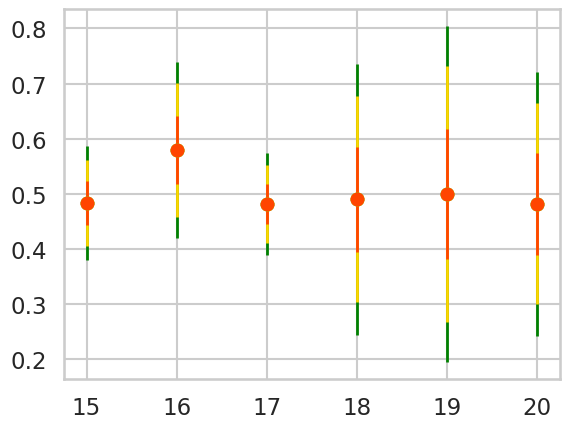

In [209]:
mpl_featureperformance(xgboost_performance)

In [208]:
plot

In [171]:
ridge_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=15,max_features=20,step_features=1,folds=3,retuniquefeatures=True,ci=0.,
                                          balancer='over_under without replacement', tolerance=0.01, target='group',
                                          model=xgboost.XGBClassifier(),score=sklearn.metrics.balanced_accuracy_score,featureselector=mrmr.mrmr_classif)

['1433G',
 'A1ATR',
 'AK1C1',
 'GDIA',
 'HV102',
 'IGHD',
 'KLK11',
 'LV327',
 'MMP2',
 'POTEJ',
 'PPT1',
 'PROC',
 'TAU',
 'TPP1']

In [14]:
ridge_performance

,feature_num,ind_scores,avg_score,stdev,ci68,yerr,features
0,5,"[0.4708333333333333, 0.39999999999999997, 0.35...",0.409722,0.046440,"(0.3635400028225291, 0.45590444162191524)",0.046182,"[[TAU, K2C7, PCP, NLGN3, ACBP], [1433G, PTPR2,..."
1,6,"[0.36666666666666664, 0.4291666666666667, 0.52...",0.441667,0.066927,"(0.37511100488681776, 0.5082223284465157)",0.066556,"[[TAU, K2C7, PCP, NLGN3, ACBP, MIA], [1433G, P..."


In [16]:
import xgboost

314463113


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


2782846335


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


91829792


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


2644553394


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


294851129


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


1390174044


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.55it/s]


2480915290


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.19it/s]


1025698583


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.81it/s]


4038474109


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.75it/s]


901531248


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.03it/s]


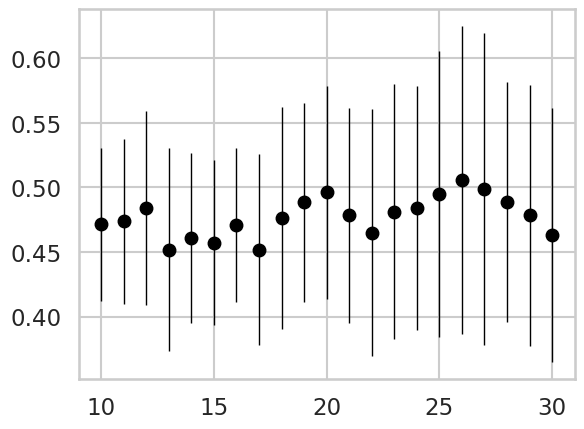

Time elapsed: 426.6683144569397


In [18]:
boost_performance =  mrmr_feature_selection(data_dev,split=0.15,min_features=10,max_features=30,step_features=1,folds=10,model=xgboost.XGBClassifier())